# Modèle pre-entrainer VGG16 : classification binaire COVID / SAIN (NORMAL) par extraction de features

In [67]:
# Chargement des modules necessaire :

import os

import cv2, numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing.image import load_img,img_to_array

In [68]:
# On declare les chemins vers les donnees :

# Image = 'Data'
        
train_data_dir = 'cleaned_data/spectrogram_train_test/Train'
validation_data_dir = 'cleaned_data/spectrogram_train_test/Test'
#test_data_dir = '../../spectrogramm/test'

# Dimmension et path :
img_width, img_height = 336, 336

ImageTRAINCOVID = os.listdir(train_data_dir + '/Cov')
ImageTRAINNORMAL = os.listdir(train_data_dir + '/noncovid')

ImageVALIDATIONCOVID = os.listdir(validation_data_dir + '/Cov')
ImageVALIDATIONNORMAL = os.listdir(validation_data_dir + '/noncovid')

#ImageTESTCOVID = os.listdir(test_data_dir + '/Covid-19')
#ImageTESTNORMAL = os.listdir(test_data_dir + '/spectro_healthy')

print('Il y a ' + str(len(ImageTRAINCOVID)) + ' images d\'entrainement de patient covid.') 
print('Il y a ' + str(len(ImageTRAINNORMAL)) + ' images d\'entrainement de patient non-covid.\n') 

print('Il y a ' + str(len(ImageVALIDATIONCOVID)) + ' images de validation de patient covid.') 
print('Il y a ' + str(len(ImageVALIDATIONNORMAL)) + ' images de validation de patient non-covid.\n')

#print('Il y a ' + str(len(ImageTESTCOVID)) + ' images de test de patient covid.') 
#print('Il y a ' + str(len(ImageTESTNORMAL)) + ' images de test de patient non-covid.')

Il y a 193 images d'entrainement de patient covid.
Il y a 865 images d'entrainement de patient non-covid.

Il y a 97 images de validation de patient covid.
Il y a 289 images de validation de patient non-covid.



TRAIN COVID


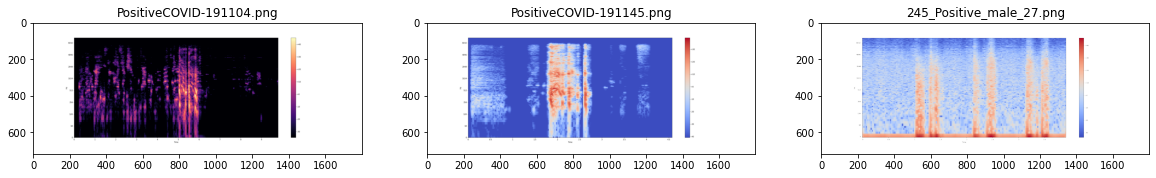

TRAIN HEALTHY


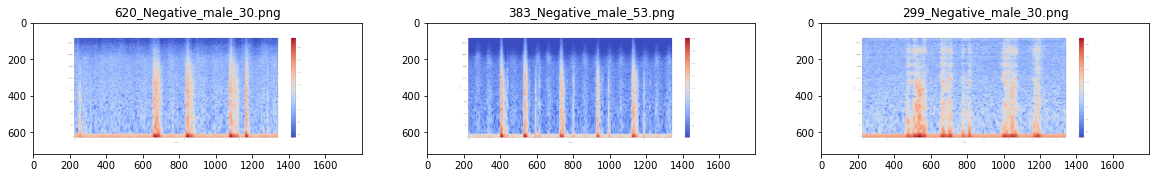

In [69]:
# Visualisation de 6 exemples en 2 lignes et 3 colonnes pour chaque classe :

# TRAIN :

print("TRAIN COVID")


# COVID  :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINCOVID = random.choice(os.listdir(train_data_dir + '/Cov'))
    plt.imshow(plt.imread(os.path.join( train_data_dir +'/Cov',randomImageTRAINCOVID)), cmap='gray')
    plt.title(randomImageTRAINCOVID)
    
plt.show()

print("TRAIN HEALTHY")
# NORMAL :

plt.figure(figsize=(20,10))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    randomImageTRAINNORMAL = random.choice(os.listdir(train_data_dir + '/noncovid'))
    plt.imshow(plt.imread(os.path.join( train_data_dir +'/noncovid',randomImageTRAINNORMAL)), cmap='gray')
    plt.title(randomImageTRAINNORMAL)
    
plt.show()


In [70]:
# Preprocessing :
# On rescale les images :
datagen = ImageDataGenerator(rescale=1./255)

# On definit la batch size :
batch_size = 32

# On prepare les tableaux de donnees depuis les images :
train_generator_bottleneck = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=False)

# On prepare les tableaux de donnees depuis les images :
validation_generator_bottleneck = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode=None,
        shuffle=True)

#test_generator_bottleneck = datagen.flow_from_directory(
        #test_data_dir,
        #target_size=(img_width, img_height),
        #batch_size=batch_size,
        #class_mode=None,
        #shuffle=True)



Found 1056 images belonging to 2 classes.
Found 384 images belonging to 2 classes.


In [71]:
# Chargement de VGG16 sans la partie fully-connected avec le reseau convolutif entrainer sur imagenet :

model_vgg = applications.VGG16(include_top=False, weights='imagenet')

In [72]:
# On utilse le model VGG16 pour extraire les features de nos images 
# (on fait recupere la sortie du reseau convolutionnel) :
train_features = model_vgg.predict_generator(train_generator_bottleneck, 1056 // batch_size)
validation_features = model_vgg.predict_generator(validation_generator_bottleneck, 384 // batch_size)
#test_features = model_vgg.predict_generator(test_generator_bottleneck, 1560 // batch_size)

# L'opération étant longue on enregistre les features obtenus :
np.save(open('models/trainFeatures_VGG16_AllData2.npy', 'wb'), train_features) # ecriture en binaire necessaire
np.save(open('models/validationFeatures_VGG16_AllData2.npy', 'wb'), validation_features) # Idem
#np.save(open('models/testFeatures_VGG16_AllData.npy', 'wb'), test_features) # Idem

In [59]:
# Si l'operation à deja été effectuer on charge les features :

train_features = np.load(open('models/trainFeatures_VGG16_AllData.npy', 'rb'))

validation_features = np.load(open('models/validationFeatures_VGG16_AllData.npy', 'rb'))
#test_features = np.load(open('models/testFeatures_VGG16_AllData.npy', 'rb'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/trainFeatures_VGG16_AllData.npy'

In [73]:
# On definit les labels :

train_labels = np.array([0] * 864 + [1] * 192)
validation_labels = np.array([0] * 288 + [1] * 96 )
#test_labels = np.array([0] * 219 + [1] * 1317)

# On peut maintenant tester plusieurs couches fully-connected à partir de ce modele :

In [74]:
# Premier modele : 
model_top1 = Sequential()
model_top1.add(Flatten(input_shape=train_features.shape[1:]))
model_top1.add(Dense(64, activation='relu'))
model_top1.add(Dropout(0.5))
model_top1.add(Dense(1, activation='sigmoid'))

# On compile :
model_top1.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top1.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_18 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                3276864   
_________________________________________________________________
dropout_18 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 1)                 65        
Total params: 3,276,929
Trainable params: 3,276,929
Non-trainable params: 0
_________________________________________________________________


In [75]:
# Second modele :
model_top2 = Sequential()
model_top2.add(Flatten(input_shape=train_features.shape[1:]))
model_top2.add(Dense(128, activation='relu'))
model_top2.add(Dropout(0.5))
model_top2.add(Dense(1, activation='sigmoid'))

# On compile :
model_top2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top2.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_19 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_38 (Dense)             (None, 128)               6553728   
_________________________________________________________________
dropout_19 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 129       
Total params: 6,553,857
Trainable params: 6,553,857
Non-trainable params: 0
_________________________________________________________________


In [76]:
# Troisieme modele :
model_top3 = Sequential()
model_top3.add(Flatten(input_shape=train_features.shape[1:]))
model_top3.add(Dense(256, activation='relu'))
model_top3.add(Dropout(0.5))
model_top3.add(Dense(1, activation='sigmoid'))

# On compile :
model_top3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

# On affiche :
model_top3.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_20 (Flatten)         (None, 51200)             0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               13107456  
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 257       
Total params: 13,107,713
Trainable params: 13,107,713
Non-trainable params: 0
_________________________________________________________________


In [77]:
# On definit les parametres pour l'entrainement :
epochs = 100


# On definit les callbacks : 
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='accuracy',mode='max',patience = 10,restore_best_weights=True,),
]

In [78]:
# On entraine le premier modèle:

historique1 = model_top1.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/100
33/33 [==============================] - 2s 59ms/step - loss: 1.5071 - accuracy: 0.7623 - val_loss: 0.6318 - val_accuracy: 0.7500
Epoch 2/100
33/33 [==============================] - 1s 26ms/step - loss: 0.6394 - accuracy: 0.7955 - val_loss: 0.8595 - val_accuracy: 0.7500
Epoch 3/100
33/33 [==============================] - 1s 25ms/step - loss: 0.5948 - accuracy: 0.8087 - val_loss: 0.7825 - val_accuracy: 0.7500
Epoch 4/100
33/33 [==============================] - 1s 25ms/step - loss: 0.4970 - accuracy: 0.8134 - val_loss: 0.8782 - val_accuracy: 0.7500
Epoch 5/100
33/33 [==============================] - 1s 25ms/step - loss: 0.5031 - accuracy: 0.8182 - val_loss: 0.9218 - val_accuracy: 0.7500
Epoch 6/100
33/33 [==============================] - 1s 26ms/step - loss: 0.5594 - accuracy: 0.8172 - val_loss: 0.8616 - val_accuracy: 0.7500
Epoch 7/100
33/33 [==============================] - 1s 25ms/step - loss: 0.5278 - accuracy: 0.8182 - val_loss: 1.0362 - val_accuracy: 0.7500
Epoch 

In [80]:
n_epochs = len(historique1.history['loss'])
GenOptimale1 = n_epochs-10
print("la generation optimale est : ",GenOptimale1)
model_top1.save_weights('weights/vgg16_lightTop_224_224_'+str(GenOptimale1)+'.h5')

la generation optimale est :  5


In [81]:
# On entraine le deuxième modèle:
historique2 = model_top2.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))

Epoch 1/100
33/33 [==============================] - 2s 59ms/step - loss: 1.5932 - accuracy: 0.7453 - val_loss: 0.6914 - val_accuracy: 0.7500
Epoch 2/100
33/33 [==============================] - 2s 47ms/step - loss: 0.5328 - accuracy: 0.8116 - val_loss: 0.6461 - val_accuracy: 0.7500
Epoch 3/100
33/33 [==============================] - 2s 67ms/step - loss: 0.5131 - accuracy: 0.8182 - val_loss: 0.7673 - val_accuracy: 0.7500
Epoch 4/100
33/33 [==============================] - 2s 52ms/step - loss: 0.5141 - accuracy: 0.8182 - val_loss: 0.8079 - val_accuracy: 0.7500
Epoch 5/100
33/33 [==============================] - 2s 50ms/step - loss: 0.5511 - accuracy: 0.8078 - val_loss: 1.0330 - val_accuracy: 0.7500
Epoch 6/100
33/33 [==============================] - 2s 48ms/step - loss: 0.4890 - accuracy: 0.8182 - val_loss: 1.0244 - val_accuracy: 0.7500
Epoch 7/100
33/33 [==============================] - 2s 48ms/step - loss: 0.4941 - accuracy: 0.8182 - val_loss: 0.8815 - val_accuracy: 0.7500
Epoch 

In [82]:
n_epochs = len(historique2.history['loss'])
GenOptimale2 = n_epochs-10
print("la generation optimale est : ",GenOptimale2)
model_top2.save_weights('weights/vgg16_mediumTop_224_224_'+str(GenOptimale2)+'.h5')

la generation optimale est :  3


In [83]:
# On entraine le troisième modèle:
historique3 = model_top3.fit(train_features, train_labels,
        epochs=epochs, 
        callbacks = my_callbacks,
        batch_size=batch_size,
        validation_data=(validation_features, validation_labels))


#The loss is calculated on training and validation and its interperation is how well the model is doing for these two sets. Unlike accuracy, loss is not a percentage. It is a summation of the errors made for each example in training or validation sets.

Epoch 1/100
33/33 [==============================] - 5s 125ms/step - loss: 1.4872 - accuracy: 0.7699 - val_loss: 0.9363 - val_accuracy: 0.7500
Epoch 2/100
33/33 [==============================] - 3s 103ms/step - loss: 0.5510 - accuracy: 0.8182 - val_loss: 0.8180 - val_accuracy: 0.7500
Epoch 3/100
33/33 [==============================] - 3s 98ms/step - loss: 0.5429 - accuracy: 0.8182 - val_loss: 0.7969 - val_accuracy: 0.7500
Epoch 4/100
33/33 [==============================] - 3s 98ms/step - loss: 0.5011 - accuracy: 0.8182 - val_loss: 0.7916 - val_accuracy: 0.7500
Epoch 5/100
33/33 [==============================] - 3s 99ms/step - loss: 0.5101 - accuracy: 0.8116 - val_loss: 0.8855 - val_accuracy: 0.7500
Epoch 6/100
33/33 [==============================] - 3s 100ms/step - loss: 0.5059 - accuracy: 0.8078 - val_loss: 0.9615 - val_accuracy: 0.7500
Epoch 7/100
33/33 [==============================] - 4s 118ms/step - loss: 0.4914 - accuracy: 0.8182 - val_loss: 1.0742 - val_accuracy: 0.7500
Ep

In [84]:
n_epochs = len(historique3.history['loss'])
GenOptimale3 = n_epochs-10
print("la generation optimale est : ",GenOptimale3)
model_top3.save_weights('weights/vgg16_heavyTop_224_224_'+str(GenOptimale3)+'.h5')

la generation optimale est :  2


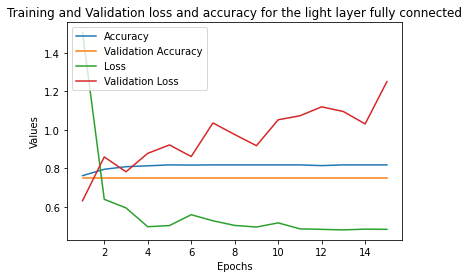

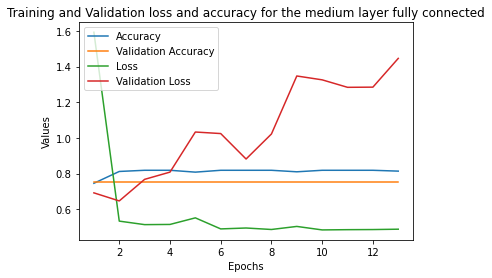

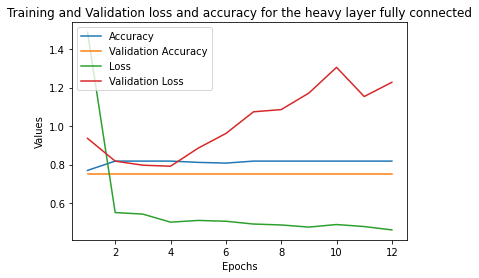

In [91]:
# Visualisation de l'entrainement :

epochs = range(1,16)
plt.plot(epochs, historique1.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique1.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique1.history['loss'], label='Loss')
plt.plot(epochs, historique1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the light layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()


epochs = range(1,14)
plt.plot(epochs, historique2.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique2.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique2.history['loss'], label='Loss')
plt.plot(epochs, historique2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the medium layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()


epochs = range(1,13)
plt.plot(epochs, historique3.history['accuracy'], label='Accuracy')
plt.plot(epochs, historique3.history['val_accuracy'], label='Validation Accuracy')
plt.plot(epochs, historique3.history['loss'], label='Loss')
plt.plot(epochs, historique3.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation loss and accuracy for the heavy layer fully connected')
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Values')
plt.show()
